# <a href="http://www.redditscore.com">![redditscore](https://s3.us-east-2.amazonaws.com/redditscore/logo.png)</a> 
***A machine learning approach to predicting how badly you'll get roasted for your sub-par reddit comments.***

Alex Hartford & Trevor Hacker

### **Dataset**

Reddit comments from September, 2018 (<a href="http://files.pushshift.io/reddit/">source</a>).  This is well over 100gb of data.  We will likely only use a subset of the data but will ultimately try to use the entire dataset.

### **Objectives**

Create a linear regression model to predict the reddit score of a comment a user is considering posting. 

Stretch goal - narrow comment scoring down by subreddit, as comment popularity will differ between reddit communities.

Allow users to use this model with a publicly available <a href="http://www.redditscore.com/api">API</a> & <a href="http://www.redditscore.com">Website</a>.

Open source the project to allow further contributions if anyone is interested.

In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

print('Libraries loaded!')

Libraries loaded!


## Import and Clean Data

In [32]:
print('Loading memes...')

# df = pd.read_json('https://s3.us-east-2.amazonaws.com/redditscore/25rows', lines=True)
df = pd.read_csv('https://s3.us-east-2.amazonaws.com/redditscore/2500rows.csv')
#df = pd.read_csv('https://s3.us-east-2.amazonaws.com/redditscore/2mrows.csv', error_bad_lines=False, engine='python')
print('Memes are fully operational!')

Loading memes...
Memes are fully operational!


In [33]:
print(df.dtypes)
df.head(10)

subreddit     object
body          object
score        float64
dtype: object


,subreddit,body,score
0,LabVIEW,Seconding this Ive used it on some pretty larg...,1.0
1,Bitcoin,I am not in debt and I shall rise again to inv...,0.0
2,worldnews,So that thin crowd was actually Russians? I wa...,7.0
3,AteTheOnion,[deleted],8.0
4,youseeingthisshit,I hope he ran away like a giggling school girl...,5.0
5,anime_irl,You can just tell that he's trying not to say ...,1.0
6,NintendoSwitch,Get Zelda,86.0
7,AskEconomics,[removed],2.0
8,mexico,[removed],1.0
9,nottheonion,Nobody likes a lingerer,2.0


Any null values need to be dropped and the score will always be an integer

In [34]:
df = df.dropna()
df['score'] = df['score'].astype('int')

In [35]:
df.head(10)

,subreddit,body,score
0,LabVIEW,Seconding this Ive used it on some pretty larg...,1
1,Bitcoin,I am not in debt and I shall rise again to inv...,0
2,worldnews,So that thin crowd was actually Russians? I wa...,7
3,AteTheOnion,[deleted],8
4,youseeingthisshit,I hope he ran away like a giggling school girl...,5
5,anime_irl,You can just tell that he's trying not to say ...,1
6,NintendoSwitch,Get Zelda,86
7,AskEconomics,[removed],2
8,mexico,[removed],1
9,nottheonion,Nobody likes a lingerer,2


## Data Analysis

In [36]:
df['score'].describe()

count    2466.000000
mean        9.634631
std       171.808223
min       -27.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      8450.000000
Name: score, dtype: float64

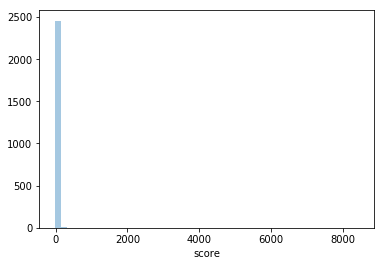

In [37]:
sns.distplot(df["score"], kde=False)

There is a significant issue with distribution

This can be solved with log scaling the score values

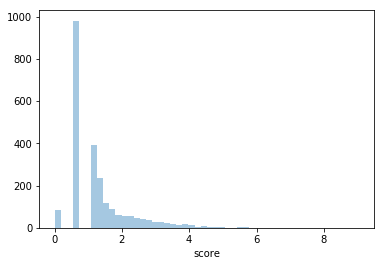

In [38]:
mask = df["score"] >= 0
sns.distplot(np.log1p(df["score"][mask]), kde=False)

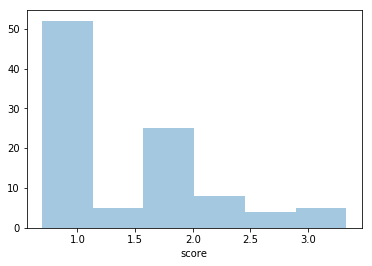

In [39]:
mask = df["score"] < 0
sns.distplot(np.log1p(-df["score"][mask]), kde=False)

## Logistic Regression Model

Firstly we are going to create a logistic regression model to determine if the score is positive, negative or zero.  
In order to do this we created a seperate column with those values.

In [40]:
df['pn_score'] = ""

for i in df['score'].index:
    if  df['score'].at[i] > 0:
        df['pn_score'].at[i] = 'positive'
    elif float(df['score'].at[i]) < 0:
        df['pn_score'].at[i] = 'negative'
    else:
        df['pn_score'].at[i] = 'zero'  

df.head(10)

,subreddit,body,score,pn_score
0,LabVIEW,Seconding this Ive used it on some pretty larg...,1,positive
1,Bitcoin,I am not in debt and I shall rise again to inv...,0,zero
2,worldnews,So that thin crowd was actually Russians? I wa...,7,positive
3,AteTheOnion,[deleted],8,positive
4,youseeingthisshit,I hope he ran away like a giggling school girl...,5,positive
5,anime_irl,You can just tell that he's trying not to say ...,1,positive
6,NintendoSwitch,Get Zelda,86,positive
7,AskEconomics,[removed],2,positive
8,mexico,[removed],1,positive
9,nottheonion,Nobody likes a lingerer,2,positive


positive    2284
negative      99
zero          83
Name: pn_score, dtype: int64


Text(0,0.5,'Number of Samples')

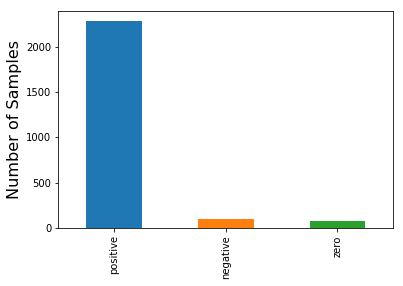

In [41]:
pn_counts = df['pn_score'].value_counts()
print(pn_counts)
pn_counts.plot.bar()
plt.ylabel("Number of Samples", fontsize=16)

Again there is an issue with distribution here, so startifying the data is very important in this case

In [42]:
log_vect = TfidfVectorizer(max_df = 0.95, min_df = 5, binary=True, stop_words='english')
text_features = log_vect.fit_transform(df.body)
print(text_features.shape)

(2466, 1130)


In [43]:
list(log_vect.vocabulary_)[:10]

['used',
 'pretty',
 'large',
 'data',
 'issue',
 'invest',
 'god',
 'willing',
 'actually',
 'joke']

In [44]:
encoder = LabelEncoder()
numerical_labels = encoder.fit_transform(df['pn_score'])

training_X, testing_X, training_y, testing_y = train_test_split(text_features,
                                                               numerical_labels,
                                                               stratify=numerical_labels)
print(training_y)

logistic_regression = SGDClassifier(loss="log", penalty="l2", max_iter=1500)
logistic_regression.fit(training_X, training_y)
pred_labels = logistic_regression.predict(testing_X)

accuracy = accuracy_score(testing_y, pred_labels)
cm = confusion_matrix(testing_y, pred_labels)

print("Accuracy:", accuracy)
print("Classes:", str(encoder.classes_))
print("Confusion Matrix:")
print(cm)

[1 1 1 ... 1 1 1]
Accuracy: 0.9254457050243112
Classes: ['negative' 'positive' 'zero']
Confusion Matrix:
[[  0  25   0]
 [  0 571   0]
 [  0  21   0]]


## Linear Regression Models
### Positive Scores

In [45]:
pos_score_df = df[df.pn_score == 'positive']

pos_score_df.head()

,subreddit,body,score,pn_score
0,LabVIEW,Seconding this Ive used it on some pretty larg...,1,positive
2,worldnews,So that thin crowd was actually Russians? I wa...,7,positive
3,AteTheOnion,[deleted],8,positive
4,youseeingthisshit,I hope he ran away like a giggling school girl...,5,positive
5,anime_irl,You can just tell that he's trying not to say ...,1,positive


In [46]:
pos_vect = TfidfVectorizer(max_df = 0.95, min_df = 5, binary=True, stop_words='english')
text_features = pos_vect.fit_transform(pos_score_df.body)
print(text_features.shape)

(2284, 1064)


In [47]:
list(pos_vect.vocabulary_)[:10]

['used',
 'pretty',
 'large',
 'issue',
 'actually',
 'joke',
 'turns',
 'deleted',
 'hope',
 'away']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(text_features, np.log1p(pos_score_df['score']))

pos_linear_regression = SGDRegressor(max_iter=1500)
pos_linear_regression.fit(X_train, y_train)
test = pos_linear_regression.predict(X_test)
mse = mean_squared_error(y_test, test)
rmse = np.sqrt(mse)
print()
print("Positive Score Model MSE:", mse)
print("Positive Score Model RMSE:", rmse)


Positive Score Model MSE: 0.7907406183843703
Positive Score Model RMSE: 0.889235974522157


### Negative Scores

In [49]:
neg_score_df = df[df.pn_score == 'negative']

neg_score_df.head()

,subreddit,body,score,pn_score
15,nfl,Defense won't win you championships anymore. I...,-8,negative
30,IdiotsInCars,I came here to say this! Regardless of opinion...,-18,negative
43,GlobalOffensive,but they knew the day the event was. go the da...,-1,negative
49,mountandblade,[deleted],-7,negative
84,formula1,Sarcasm is generally supposed to be humorous b...,-3,negative


In [50]:
neg_vect = TfidfVectorizer(max_df = 0.95, min_df = 5, binary=True, stop_words='english')
text_features = neg_vect.fit_transform(neg_score_df.body)
print(text_features.shape)

(99, 7)


In [51]:
list(neg_vect.vocabulary_)[:10]

['deleted', 'know', 'like', 'just', 'people', 'sure', 'don']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(text_features, -np.log1p(-neg_score_df["score"]))

neg_linear_regression = SGDRegressor(max_iter=1500)
neg_linear_regression.fit(X_train, y_train)
test = neg_linear_regression.predict(X_test)
mse = mean_squared_error(y_test, test)
rmse = np.sqrt(mse)
print()
print("Negative Score Model MSE:", mse)
print("Negative Score Model RMSE:", rmse)


Negative Score Model MSE: 0.6601192039232506
Negative Score Model RMSE: 0.8124772020944653


## Combining Models

First the logistic regression model will be used to preditc whether or not the score is negative or positive, then depending on the outcome the appropriate linear regression model will be used to predict the score value

In [53]:
a = (["Absolutely brutal episode I followed the show with my roommates  We all watched it recorded but the day it came out and had about 6 people together. All deep fans all super excited at new episodes and very "])

logistic_result = logistic_regression.predict(log_vect.transform(a))
print('Logistic Result: ')
print(logistic_result)
print()

if(logistic_result) == 1:
    linear_result = pos_linear_regression.predict(pos_vect.transform(a))
    print('Linear Result: ')
    print(linear_result)
elif(logistic_result) == 0:
    linear_result = pos_linear_regression.predict(pos_vect.transform(a))
    print('Linear Result: ')
    print(linear_result)

Logistic Result: 
[1]

Linear Result: 
[1.72853979]
